# Example of a DEM interpolation

In [1]:
from pathlib import Path
import skimage.io
import verde as vd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Make some fake data using the Kilauea DEM.

In [2]:
kilauea = skimage.io.imread(Path("../data/kilauea/kilauea2009.tif"))[::-10, ::10]
kilauea[kilauea == -9999] = np.nan
x, y = np.meshgrid(np.arange(kilauea.shape[1]), np.arange(kilauea.shape[0]))
x = x[~np.isnan(kilauea)].ravel()
y = y[~np.isnan(kilauea)].ravel()
kilauea = kilauea[~np.isnan(kilauea)].ravel()
(x, y), kilauea = vd.BlockReduce(np.median, spacing=4).filter((x, y), kilauea)
np.random.seed(0)
x += np.random.uniform(-2, 2, size=x.size)
y += np.random.uniform(-2, 2, size=y.size)
kilauea.shape

/home/leo/miniconda3/envs/remote-sensing/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3098,)

Use Verde to interpolate the points into a DEM.

In [3]:
kilauea_grid = vd.Spline(damping=1e-8, mindist=1).fit((x, y), kilauea).grid(spacing=4)
kilauea_grid = vd.distance_mask((x, y), maxdist=5, grid=kilauea_grid)

Make a nice figure.

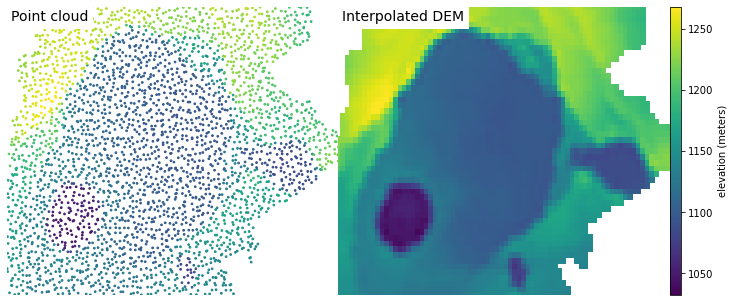

In [5]:
fig = plt.figure(figsize=(10, 4))

grid = GridSpec(1, 61, figure=fig, wspace=0, hspace=0)
axes =[
    fig.add_subplot(grid[0, 0:30]),
    fig.add_subplot(grid[0, 30:60]),
]
ax3 = fig.add_subplot(grid[0, 60])
ax1, ax2 = axes

vmin, vmax = kilauea.min(), kilauea.max()

ax1.scatter(x, y, c=kilauea, s=3, cmap="viridis", vmin=vmin, vmax=vmax)
ax1.text(
    3, 201, 
    f"Point cloud", 
    color="black", 
    fontweight="normal", 
    fontsize=14,
    verticalalignment="top",
    backgroundcolor="white",
)    

tmp = kilauea_grid.scalars.plot(ax=ax2, vmin=vmin, vmax=vmax, add_colorbar=False)
ax2.text(
    3, 201, 
    f"Interpolated DEM", 
    color="black", 
    fontweight="normal", 
    fontsize=14,
    verticalalignment="top",
    backgroundcolor="white",
)    

fig.colorbar(tmp, cax=ax3, label="elevation (meters)")

for ax in axes:
    ax.axis("off")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig("../lectures/images/dem-generation.png", dpi=200, bbox_inches="tight", pad_inches=0)